# ECSE 415 Assignment 2
### Tyler Young | 260730324
### Feb. 26, 2020

In [365]:
# imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

## Part 1: Image Stitching

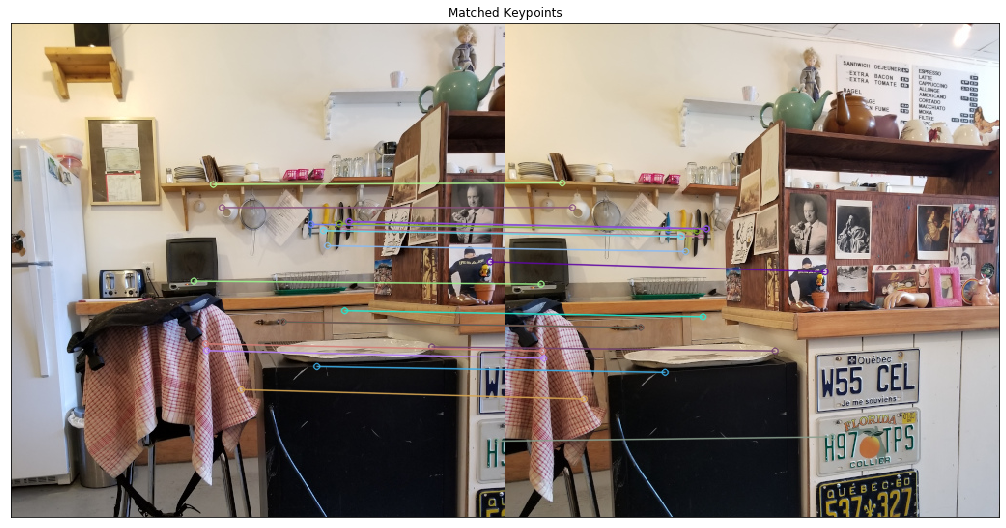

In [366]:
# Read images to stitch
imgl = cv2.imread('imgL3.jpg')
imgc = cv2.imread('imgC3.jpg')
imgr = cv2.imread('imgR3.jpg')

imgl = cv2.cvtColor(imgl, cv2.COLOR_BGR2RGB)
imgc = cv2.cvtColor(imgc, cv2.COLOR_BGR2RGB)
imgr = cv2.cvtColor(imgr, cv2.COLOR_BGR2RGB)

# Compute keypoints and descriptors
sift_obj = cv2.xfeatures2d.SIFT_create()
keypoints_l, descriptors_l = sift_obj.detectAndCompute(imgl, None)
keypoints_r, descriptors_r = sift_obj.detectAndCompute(imgr, None)
keypoints_c, descriptors_c = sift_obj.detectAndCompute(imgc, None)

# create BFMatcher object
bf = cv2.BFMatcher()

# Match descriptors.
matches = bf.match(descriptors_l,descriptors_c)
matches2 = bf.match(descriptors_c, descriptors_r)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw keypoints 
imgmatch1 = cv2.drawMatches(imgl,keypoints_l,imgc,keypoints_c, matches[:20], imgl, flags=2)

# Arrange matching keypoints in two separate lists
GoodMatches = []
for i, m in enumerate(matches):
    if m.distance < 1000:
        GoodMatches.append((m.trainIdx, m.queryIdx))

mpl = np.float32([keypoints_l[i].pt for (__,i) in GoodMatches])
mpc = np.float32([keypoints_c[i].pt for (i,__) in GoodMatches])

#print(len(mpc), len(mpl))
#print("mpc", mpc)
#print("mpl", mpl)

# find homography and wrap image accordingly
H, __ = cv2.findHomography(mpc, mpl, cv2.RANSAC, 4)
wimg = cv2.warpPerspective(imgc, H, (imgc.shape[1]+imgl.shape[1],imgc.shape[0]))
wimg[:,:imgl.shape[1],:] = imgl

# preview matching keypoints
plt.figure(figsize=(20,20))
plt.subplot(211)
plt.imshow(imgmatch1)
plt.title("Matched Keypoints"), plt.xticks([]), plt.yticks([])
plt.show()

In [367]:
# warpPerspectivePadded function from the assignment 
def warpPerspectivePadded(
        imgl, H, imgr_shape):
    """Performs an affine or Euclidean/rigid warp with padding.
    Parameters
    ----------
    imgl : image to be warped i.e. left image
    imgr : shape of static image i.e. shape of central image
    M : `3x3` Homography matrix.
    Returns
    -------
    src_warped : padded and warped source image
    """
    
    src = imgl
    dst_shape = imgr_shape
    M = H
    
    # it is enough to find where the corners of the image go to find
    # the padding bounds; points in clockwise order from origin
    _, src_w = src.shape[:2]
    lin_pts = np.array([
        [0, src_w],
        [0, 0],
        [1, 1]])
    # transform points
    transf_lin_pts = M.dot(lin_pts) #M[:, :2].dot(lin_pts) + M[:, 2].reshape(3, 1)
    transf_lin_pts /= transf_lin_pts[-1:,:]
    
    # find min and max points
    min_x = np.floor(np.min(transf_lin_pts)).astype(int)
    max_x = np.ceil(np.max(transf_lin_pts)).astype(int)

    # add translation to the transformation matrix to shift to positive values
    anchor_x = 0
    transl_transf = np.eye(3,3)
    if min_x < 0:
        anchor_x = -min_x
        transl_transf[0,2] = anchor_x
        
    shifted_transf = transl_transf.dot(M)
    shifted_transf /= shifted_transf[2,2]

    # create padded destination image
    dst_h, dst_w,_ = dst_shape
    dst_pad_w = anchor_x + max(max_x, dst_w)
    src_warped = cv2.warpPerspective(src, shifted_transf, (dst_pad_w, dst_h), borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return src_warped

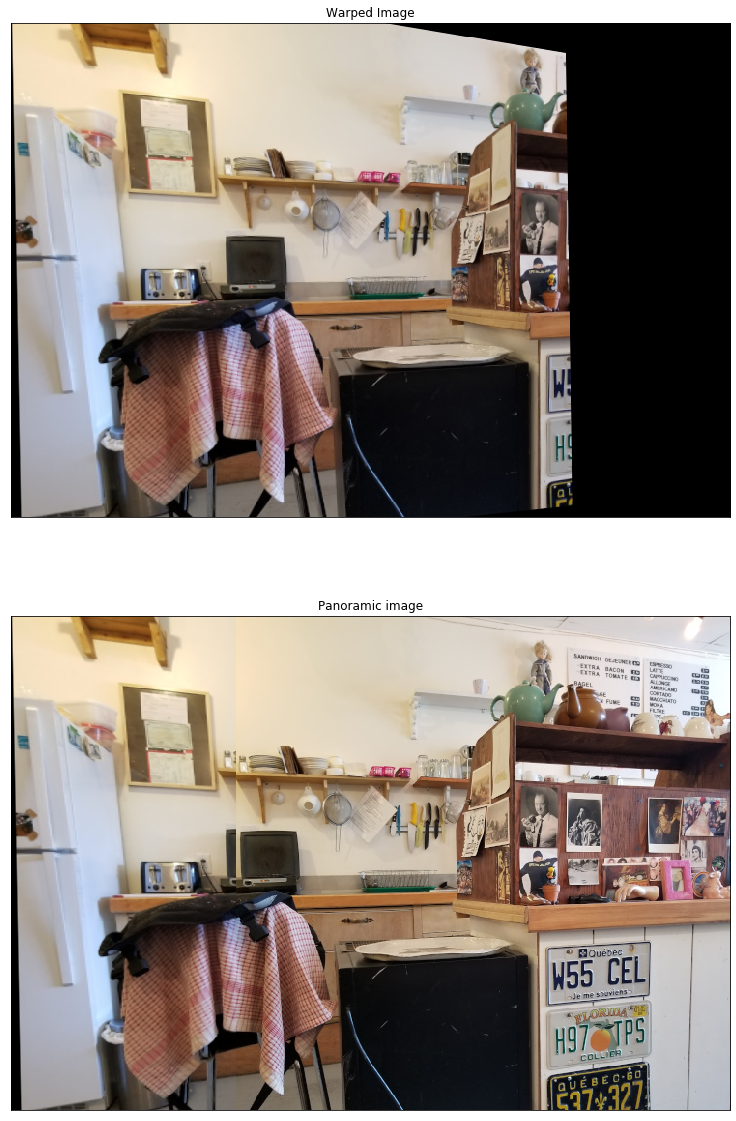

In [368]:
# finding homography using manual RANSAC implementation

# creating a method called ransac to perform RANSAC as per slide 52
def ransac(mpl, mpr, thresh, samples):
    
    inliersl = None
    inliersr = None
    count = 0
    
    # loop through 1000 samples and find the best set of inliers for the left and right images
    for i in range(samples):
        
        rand = np.random.randint(0, len(mpl), 4)
        H, __ = cv2.findHomography(mpl[rand], mpr[rand], 0)
        #print("H", H.shape)
        
        #print("mpl", mpl.shape)
        conv = cv2.convertPointsToHomogeneous(mpl)
        #print("conv", conv.shape)

        proj = np.array([np.matmul(H, np.transpose(p)) for p in conv])
        #print("proj", proj.shape)
        
        conv2 = cv2.convertPointsFromHomogeneous(proj)
        #print("conv2", conv2)

        conv2 = np.reshape(conv2, (conv2.shape[0], 2))
        diff = conv2 - mpr
        #print("diff", diff.shape)
        #print("diff", diff)
        
        dist = np.linalg.norm(diff, axis=1)
        #print("dist", dist.shape)
        #print("dist", dist)
        
        # Only increment the counter if the calculated distances are less than the threshold
        k = len([x for x in dist if x < thresh])
        
        # set the counter if it finds a better set of points
        if k > count:
            count = k
            inliersl = np.array([mpl[i] for i in range(dist.size) if dist[i] < thresh])
            inliersr = np.array([mpr[i] for i in range(dist.size) if dist[i] < thresh])
            
    H, __ = cv2.findHomography(inliersl, inliersr, 0)
    #print("H", H)
    return H

# Calculate the best homography
Hfin = ransac(mpl, mpc, 3, 1000)

# Warp the left image
wimg = warpPerspectivePadded(imgl, Hfin, imgc.shape)
imglw = wimg.copy()
wimg[:,wimg.shape[1] - imgc.shape[1]:,:] = imgc

# preview images
plt.figure(figsize=(20,20))
plt.subplot(211)
plt.imshow(imglw)
plt.title("Warped Image"), plt.xticks([]), plt.yticks([])
plt.subplot(212)
plt.imshow(wimg)
plt.title("Panoramic image"), plt.xticks([]), plt.yticks([])
plt.show()

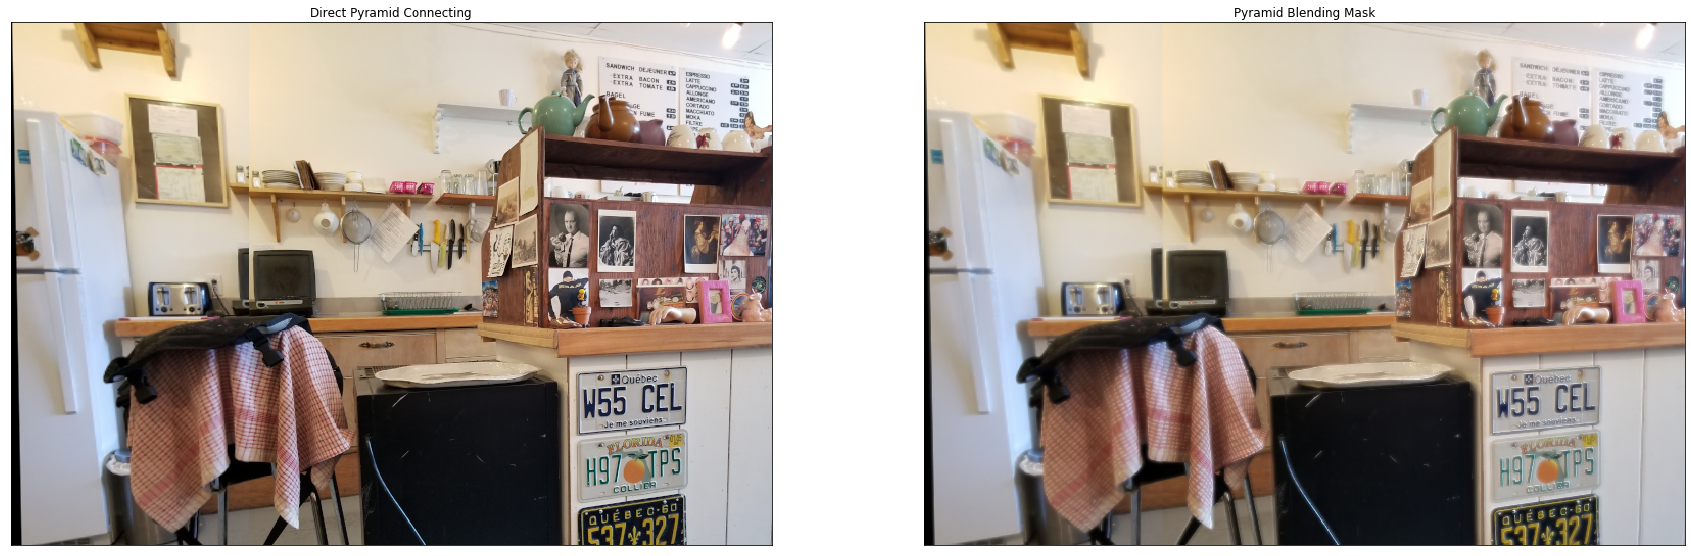

In [369]:
# apply pyramid image blending to the original left and central image
# reduced pyramid levels for image clarity, higher levels yield worse image resolution and color accuracy
levels = 2

# generate Gaussian pyramid for A
G = imglw.copy()
gpL = [G]
for i in range(levels):
    G = cv2.pyrDown(G)
    gpL.append(G)
# generate Gaussian pyramid for B
G = imgc.copy()
gpC = [G]
for i in range(levels):
    G = cv2.pyrDown(G)
    gpC.append(G)
# generate Laplacian Pyramid for A
lpL = [gpL[levels-1]]
for i in range(levels-1,0,-1):
    GE = cv2.pyrUp(gpL[i], dstsize=(gpL[i-1].shape[1],gpL[i-1].shape[0]))
    L = cv2.subtract(gpL[i-1],GE)
    lpL.append(L)
# generate Laplacian Pyramid for B
lpC = [gpC[levels-1]]
for i in range(levels-1,0,-1):
    GE = cv2.pyrUp(gpC[i], dstsize=(gpC[i-1].shape[1],gpC[i-1].shape[0]))
    L = cv2.subtract(gpC[i-1],GE)
    lpC.append(L)
# Now add left and right halves of images in each level
LS = []
for la,lb in zip(lpL,lpC):
    ls = np.hstack((la[:,0:la.shape[1] - lb.shape[1]:], lb[:,:]))
    LS.append(ls)
# now reconstruct
ls_ = LS[0]
for i in range(1,levels):
    ls_ = cv2.pyrUp(ls_, dstsize=(LS[i].shape[1],LS[i].shape[0]))
    ls_ = cv2.add(ls_, LS[i])
# image with direct connecting
real = np.hstack((imglw[:,0:imglw.shape[1] - imgc.shape[1]:],imgc[:,:]))

# display results
plt.figure(figsize=(30,30))
plt.subplot(121), plt.imshow(real)
plt.title('Direct Pyramid Connecting'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(ls_)
plt.title('Pyramid Blending Mask'), plt.xticks([]), plt.yticks([])
plt.show()

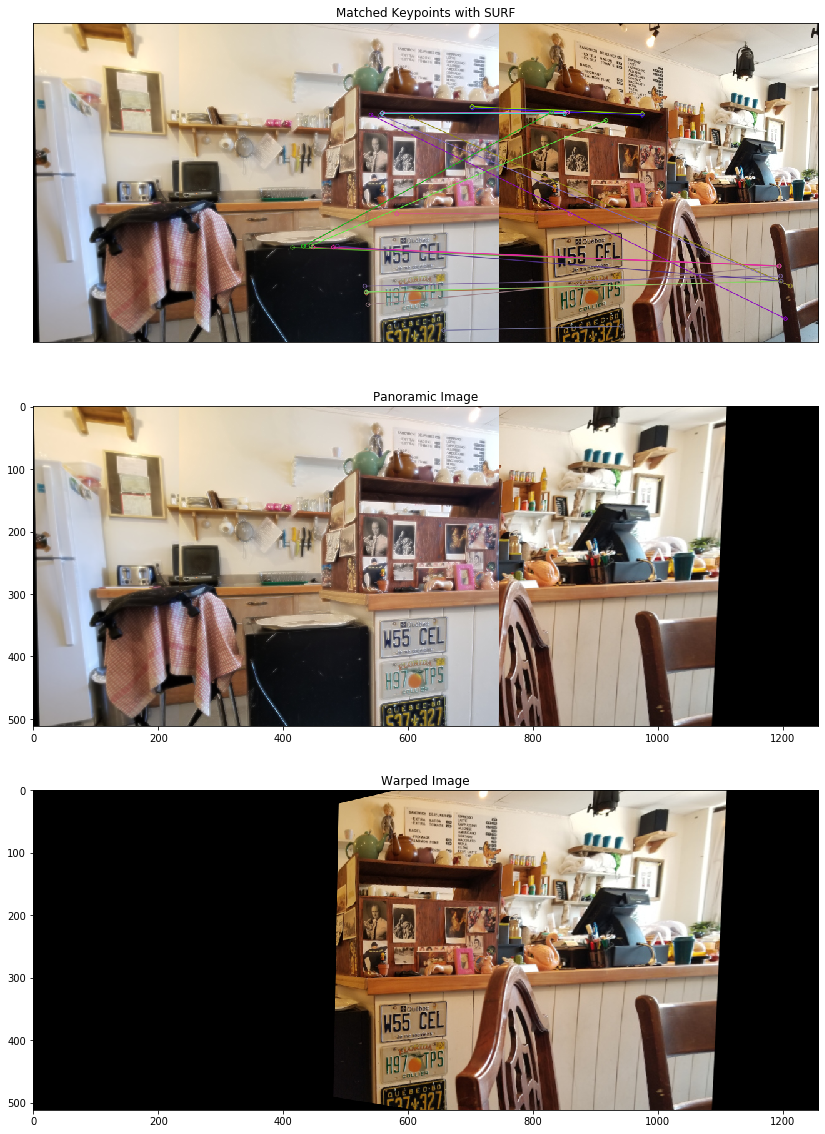

In [370]:
# SURF implementation

imgpylc = ls_.copy()

# Compute keypoints and descriptors
sift_obj = cv2.xfeatures2d.SURF_create()
keypoints_l, descriptors_l = sift_obj.detectAndCompute(imgpylc, None)
keypoints_r, descriptors_r = sift_obj.detectAndCompute(imgr, None)

# create BFMatcher object
bf = cv2.BFMatcher()

# Match descriptors.
matches = bf.match(descriptors_l,descriptors_r)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw keypoints 
imgmatch1 = cv2.drawMatches(imgpylc,keypoints_l,imgr,keypoints_r, matches[:20], imgpylc, flags=2)

# Arrange matching keypoints in two separate lists
GoodMatches = []
for i, m in enumerate(matches):
    if m.distance < 1000:
        GoodMatches.append((m.trainIdx, m.queryIdx))

mpl = np.float32([keypoints_l[i].pt for (__,i) in GoodMatches])
mpc = np.float32([keypoints_r[i].pt for (i,__) in GoodMatches])

# find homography and wrap image accordingly
H, __ = cv2.findHomography(mpc, mpl)

Hf = ransac(mpc, mpl, 3, 1000)

wimg2 = cv2.warpPerspective(imgr, Hf, (imgr.shape[1]+imgpylc.shape[1],imgr.shape[0]))
wimg2clean = wimg2.copy()
wimg2[:,:imgpylc.shape[1],:] = imgpylc

# preview images
plt.figure(figsize=(20,20))
plt.subplot(311)
plt.imshow(imgmatch1)
plt.title("Matched Keypoints with SURF"), plt.xticks([]), plt.yticks([])
plt.subplot(312)
plt.imshow(wimg2)
plt.title("Panoramic Image")
plt.subplot(313)
plt.imshow(wimg2clean)
plt.title("Warped Image")
plt.show()

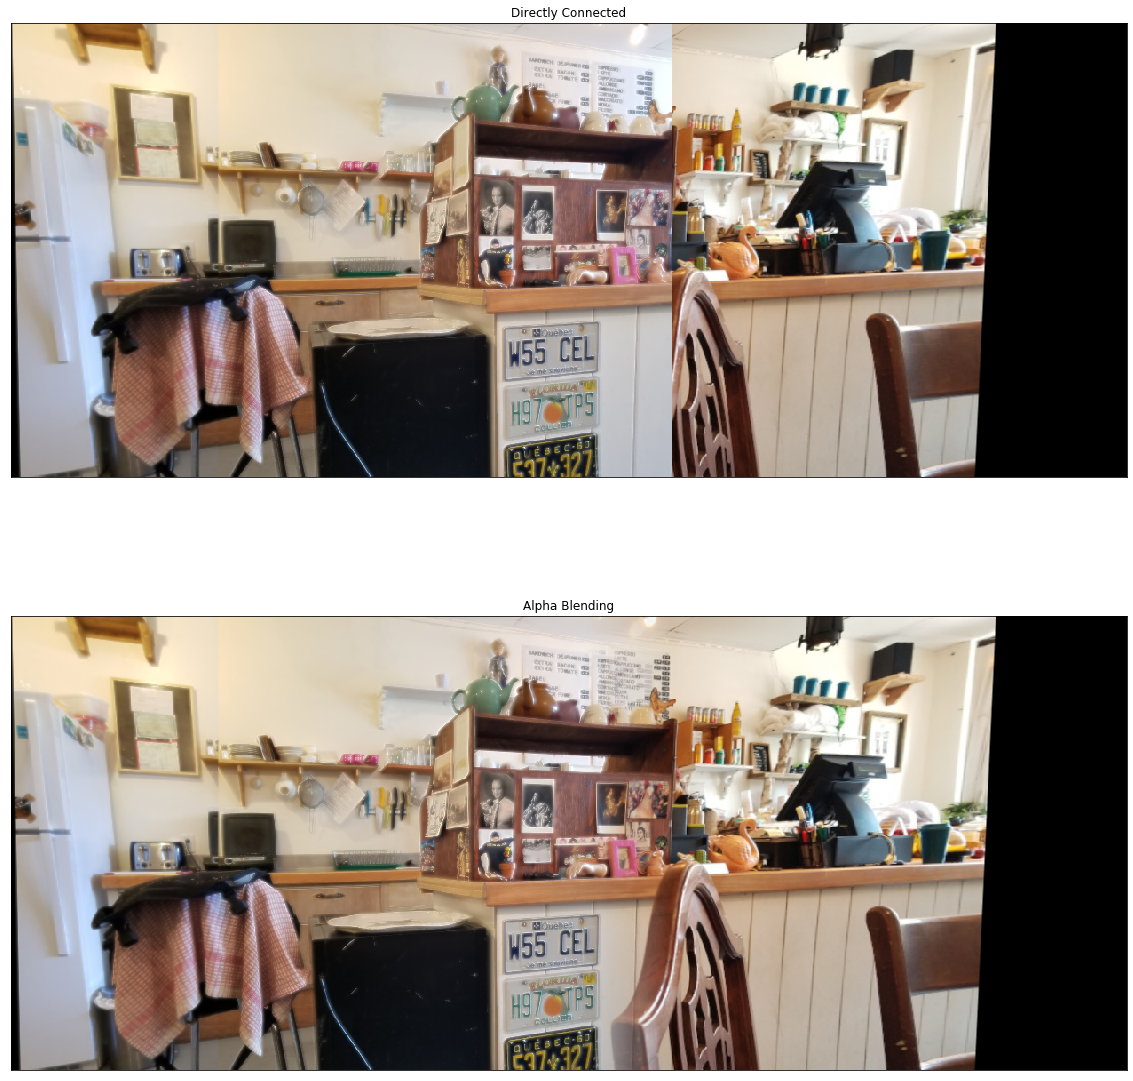

In [371]:
# apply linear blending

wimgr = wimg2clean.copy()
imgpan = imgpylc.copy()

temp = np.zeros((wimgr.shape))
temp[:, :imgpan.shape[1],:] = imgpan

RAMP_SIZE = 100

ramp = np.zeros((wimgr.shape[1]))

# create ramp
for i in range(RAMP_SIZE):
    ramp[i+imgpan.shape[1]-RAMP_SIZE] = i/RAMP_SIZE
ramp[imgpan.shape[1]:] = 1

# Now blend
I_blend = (1-ramp.reshape(1,-1,1)) * temp + ramp.reshape(1,-1,1)*wimgr
I_blend = np.uint8(I_blend)  # convert back to uint8

# display images
plt.figure(figsize=(20,20))
plt.subplot(211), plt.imshow(wimg2)
plt.title("Directly Connected"), plt.xticks([]), plt.yticks([])
plt.subplot(212), plt.imshow(I_blend)
plt.title("Alpha Blending"), plt.xticks([]), plt.yticks([])
plt.show()

Speaking to the effectiveness of pyramid blending, I found that with the images I used, the blending was very poor. Looking at the result, with a level higher than 2, the color in the image is skewed and pale, and the sharpness of the image is lost. Therefore, carrying this result forwards, it reduces the effectiveness of the SURF technique to identify matching descriptors and eventually ends in a failed panorama. This is why I elected to choose a relative low pyramid level to reduce the amount of blurring. Linear blending on the other hand worked very well. With the images I provided, difficulty arose with the chair which sat in the foreground of the image and only appeared in the right most image. As a result, when stitching together a panorama, it was often lost as the chair didn't have any matching points with the left and center images. Implementation of the linear blending was also much more straight forward, and it resulted in bringing back the chair into the panorama, which was a huge plus. 

The benefit of pyramid blending is that it applies to images of a larger variance in resolution, because the Laplacian is calculated when performing pyramid blending, differences in intensity are analyzed rather than fine details. Whereas with linear blending, it's taking something like a percent of one image and applying it to another and that varies along some ramp. Pyramid blending, when applied right, can leave an image with a seamless stitch, while not leaving out much information. Linear blending on the other hand will tend to lead to ghosting, where transparencies in images will show up incorrectly, as with my panoramic and the chair. However, in practice, with a more complicated image, and with descriptors that aren't necessarily localized, pyramid blending proved to be less effective than linear blending. 

## Part 2: Classification

### Training

In [372]:
# resize training images to 128 x 128 pixels
# load images
data = os.listdir('./train_set/')
size = (128, 128)
img_train = []

# resize and store training and test images 
for i in range(len(data)):
    name = data[i]
    img = cv2.imread('./train_set/' + name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_train.append(img)

In [373]:
# define a function to compute HoG features
def computeHoG(img_train):
    img_train = [cv2.resize(img, (128, 128)) for img in img_train]
    
    cell_size = (4, 4)  # h x w in pixels
    block_size = (2, 2)  # h x w in cells
    nbins = 9  # number of orientation bins

    # create HoG Object
    # winSize is the size of the image cropped to multiple of the cell size
    # all arguments should be given in terms of number of pixels
    hog = cv2.HOGDescriptor(_winSize=(128, 128),
                            _blockSize=(block_size[1] * cell_size[1],
                                        block_size[0] * cell_size[0]),
                            _blockStride=(cell_size[1], cell_size[0]),
                            _cellSize=(cell_size[1], cell_size[0]),
                            _nbins=nbins)

    n_cells = (128 // cell_size[0], 128 // cell_size[1])

    # Compute HoG features
    
    hog_feats = []
    
    for img in img_train:
        hog_feats.append(hog.compute(img) \
                    .reshape(n_cells[1] - block_size[1] + 1,
                            n_cells[0] - block_size[0] + 1,
                            block_size[1], block_size[0], nbins) \
                   .transpose((1, 0, 3, 2, 4)))  # index blocks by rows first   
        
    return hog_feats

In [374]:
# computes HoG features
# calculate the mean feature map across training images
feature_mean = np.mean(computeHoG(img_train), axis=0)
# print("feat", feature_mean.shape)

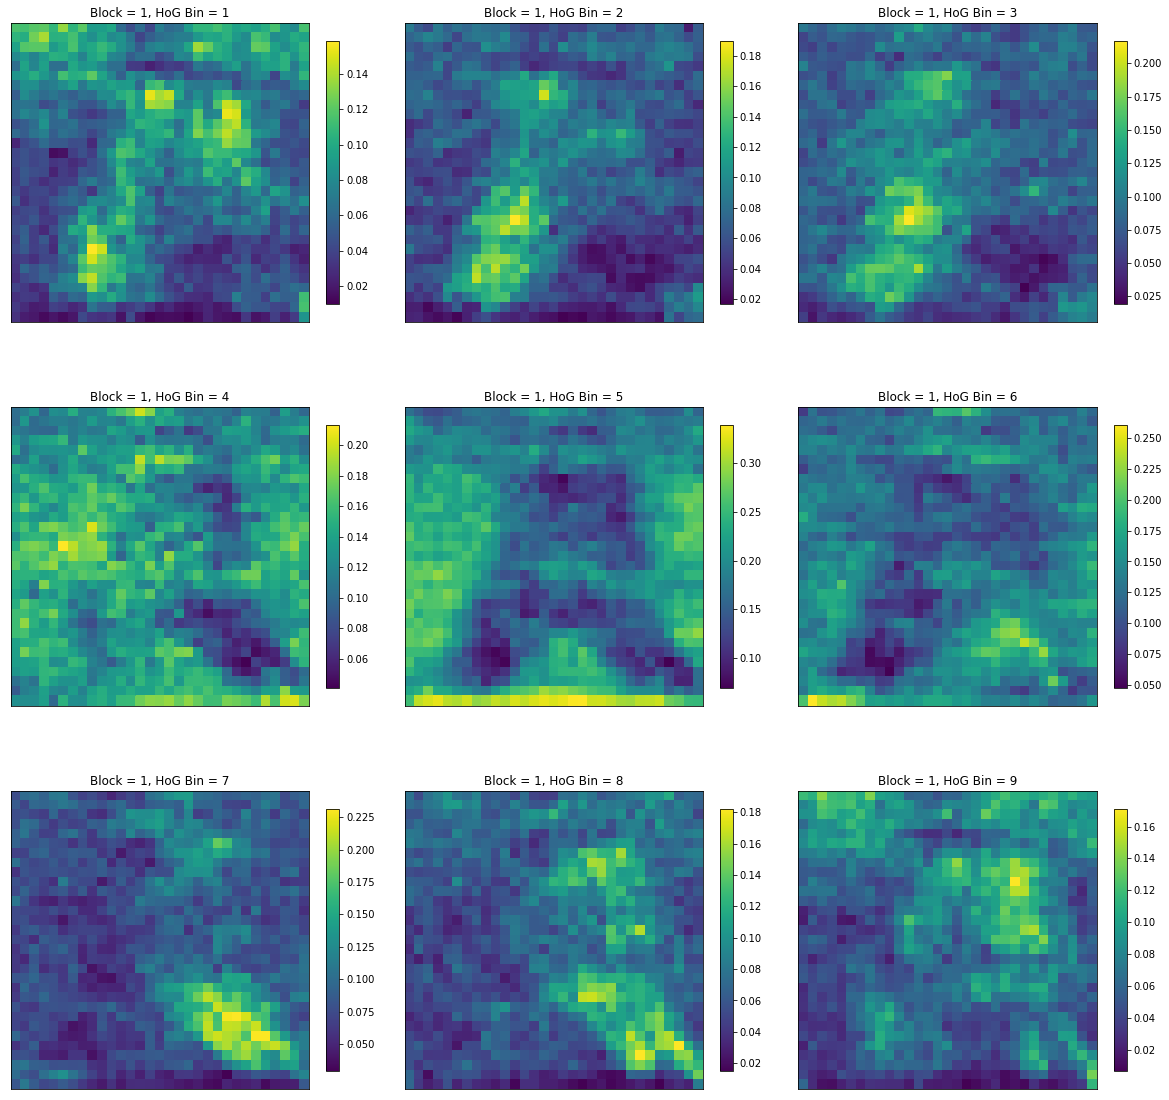

In [375]:
# displays HoG feature 
plt.figure(figsize = (20, 20))
for k in range(0, 9):
    plt.subplot(3, 3, k+1)
    plt.pcolor(feature_mean[:,:,0,0,k])
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(str.format("Block = 1, HoG Bin = {}", k + 1)), plt.xticks([]), plt.yticks([])
    plt.colorbar(fraction=0.04)
plt.show()

### Testing

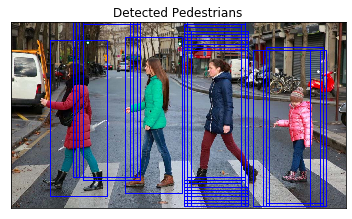

In [376]:
# read test image
img_test = cv2.imread('test_image.png')
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
test_list = []
rect_list = []
wind_size = (475,175)
stride_size = (10,10)

# crop points to extract the pedestrians
for i in range(0, img_test.shape[0] - wind_size[0], stride_size[0]):
    for j in range(0, img_test.shape[1] - wind_size[1], stride_size[1]):
        img = img_test[i : i + wind_size[0],j : j + wind_size[1],:]
        test_list.append(img)
        rect_list.append(((j,i),(j + wind_size[1], i + wind_size[0])))
        
hog_feat = computeHoG(test_list)

# calculate Euclidean distance
Edist = [np.linalg.norm(hog_feat[i] - feature_mean) for i in range(len(hog_feat))]

# emperically determine the threshold
thresh2 = 18.38

# draw rectangles around the detected pedestrians
for i in range(len(Edist)):
    if Edist[i] < thresh2:
        img_test = cv2.rectangle(img_test, rect_list[i][0], rect_list[i][1], (0,0,255), 2)

plt.subplot(111)
plt.title("Detected Pedestrians")
plt.imshow(img_test), plt.xticks([]), plt.yticks([])
plt.show()

With respect to determining the values of the window, stride and threshold, the window size was chosen such that it was a bit bigger than a person in the image. This would allow for the windows to easily detect them when either a part or an entire pedestrian is captured. I found that making the window size taller, actually helps with finding pedestrians on the road. The stride size was chosen to be 10x10 which allows for a reasonable computation time as well as high accuracy when moving the window around. The threshold was then toyed around with at these two values until each pedestrian was identified with a rectancle. 

With regards to the performance of the method above to detect the four pedestrians, it was found to successfully detect all pedestrians (with some bias towards some) but, also yielded a high number of false positives. The false positives can be seen by the rectangles outlining the space between the lady in the red jacket and the lady in the green jacket. The threshold, window size and stride size all needed to be adjusted to find a happy balance between actually detecting all of the pedestrians and getting false positives. 

In order to improve the results of this method, I believe that taking the mean of the test set feature is not an entirely full proof method of collecting the test sample data. There are large variances in the test set image background which I think, when averaged out, tend to make the HoG features inaccurate when put to the test. Other ways to improve this method would be to increase the test-set size as a sample size of 30 is quite small. Probably a set on the order of 100s would yield much more accurate results